<a href="https://colab.research.google.com/github/Varun0801/Deep_Learning_Essentials/blob/master/CNN_Training_Learning_Building_CNN_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load Dependencies
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

2.3.0


In [ ]:
# Main Objective — Building & Deploying an Apparel Classifier
"""
We will keep things simple here with regard to the key objective. 
We will build a simple apparel classifier by training models on the very
famous Fashion MNIST dataset based on Zalando’s article images — consisting
of a training set of 60,000 examples and a test set of 10,000 examples. 
Each example is a 28x28 grayscale image, associated with a label from 10 
classes. The idea is to classify these images into an apparel category 
amongst 10 categories on which we will be training our models on.

Fashion MNIST is intended as a drop-in replacement for the classic MNIST 
dataset—often used as the "Hello, World" of machine learning programs for 
computer vision. You can access the Fashion MNIST directly from TensorFlow.

Note: Although these are really images, they are loaded as NumPy arrays and 
not binary image objects.

We will build the following two deep learning CNN (Convolutional Neural 
Network) classifiers in this notebook.

A simple CNN trained from scratch
Fine-tuning a pre-trained VGG-19 CNN
The idea is to look at how to build your own CNN from scratch 
and also to briefly look at transfer learning where you fine-tune a pre-trained 
model to adapt it to classify images based on your dataset.
"""


In [2]:
# Load Dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


In [ ]:
"""
Brief on CNNs
CNNs typically consist of multiple convolution and pooling layers which 
help the deep learning model in automatically extracting relevant features 
from visual data like images. Due to this multi-layered architecture, CNNs 
learn a robust hierarchy of features, which are spatial, rotation, and translation invariant.

The key operations in a CNN model are depicted in the figure above. Any image
can be represented as a tensor of pixel values. The convolution layers help in extracting 
features from this image (forms feature maps). Shallower layers (closer to the input data) 
in the network learn very generic features like edges, corners and so on. 
Deeper layers in the network (closer to the output layer) learn very specific 
features pertaining to the input image. The following graphic helps summarize the key 
aspects of any CNN model.



We will be building a CNN from scratch as well as leverage the power of transfer learning, 
where we use pre-trained deep learning CNNs in this tutorial.

"""

In [3]:
# 1. Training a simple CNN Classifier from Scratch
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


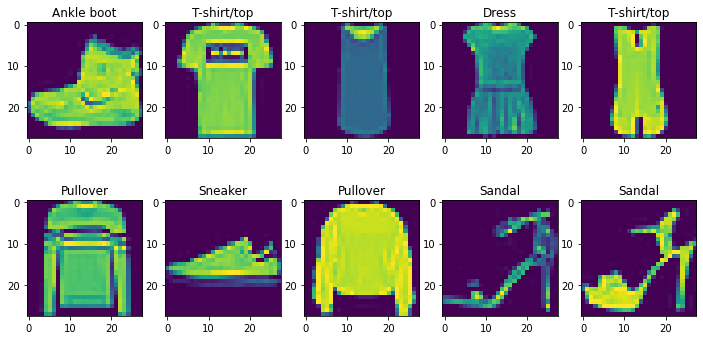

In [4]:
ig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
    idx = i // 5
    idy = i % 5 
    ax[idx, idy].imshow(train_images_gr[i].reshape(28,28))
    ax[idx, idy].set_title(class_names[train_labels[i]])

In [5]:
# Build CNN Model Architecture
# We will now build our basic 2-layer CNN model architecture
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               205056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [6]:
# Model Training
# Let’s train our model for 100 epochs and look at the performance. 
# We do apply an early-stopping to stop the model training immediately 
# once we don't see an improvement in validation-loss over the last 2 
# epochs using the EarlyStopping callback.

EPOCHS = 100
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5284 - accuracy: 0.8049 - val_loss: 0.3643 - val_accuracy: 0.8603
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3519 - accuracy: 0.8717 - val_loss: 0.3131 - val_accuracy: 0.8807
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3074 - accuracy: 0.8869 - val_loss: 0.2948 - val_accuracy: 0.8888
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2739 - accuracy: 0.8990 - val_loss: 0.2711 - val_accuracy: 0.9018
Epoch 5/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2508 - accuracy: 0.9076 - val_loss: 0.2650 - val_accuracy: 0.9045
Epoch 6/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2361 - accuracy: 0.9134 - val_loss: 0.2712 - val_accuracy: 0.9010
Epoch 7/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2190 - accuracy: 0.9194 - val_loss: 0.2642 - val_ac

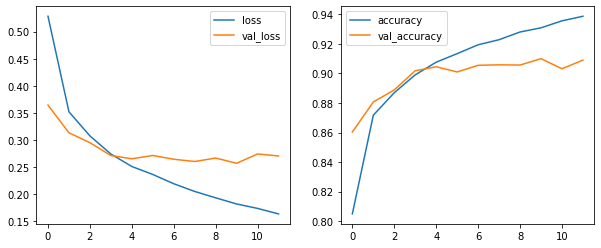

In [7]:
# Plot Learning Curves
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [8]:
# Evaluate Model Performance on Test Data
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[3.8724488e-12, 3.3206495e-16, 6.4855391e-12, 6.0909059e-15,
        9.0094924e-14, 7.8834653e-08, 4.3281172e-13, 9.0486992e-08,
        1.1446326e-12, 9.9999988e-01],
       [1.7403901e-08, 2.2928283e-19, 1.0000000e+00, 1.2635453e-14,
        1.1664603e-09, 4.4839929e-17, 5.1074043e-08, 1.1767520e-22,
        2.4061697e-12, 4.1186274e-22],
       [6.4569072e-15, 1.0000000e+00, 1.4389042e-19, 6.6289784e-19,
        1.8297255e-19, 2.0051292e-24, 5.9797367e-21, 2.6077523e-37,
        4.4143271e-23, 1.0557158e-36],
       [3.2264285e-14, 1.0000000e+00, 6.0411761e-16, 2.2090310e-13,
        4.8581165e-14, 7.4709687e-22, 2.1791324e-15, 4.7065470e-29,
        5.5259058e-20, 2.7595419e-29],
       [3.2319763e-01, 6.4111582e-06, 1.1790886e-02, 1.3546806e-03,
        1.6213666e-03, 1.9167179e-07, 6.6197419e-01, 4.1723929e-08,
        5.4147753e-05, 4.1816406e-07]], dtype=float32)

In [9]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.85      0.89      0.87      1000
       Dress       0.93      0.90      0.91      1000
        Coat       0.85      0.87      0.86      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.73      0.68      0.71      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.97      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.90      0.91      0.90     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,862,0,20,12,4,1,95,0,6,0
Trouser,3,972,0,13,3,0,7,0,2,0
Pullover,13,1,888,7,40,0,50,0,1,0
Dress,25,3,11,895,23,0,40,0,2,1
Coat,0,1,52,22,872,0,52,0,1,0
Sandal,1,0,0,0,0,966,0,23,0,10
Shirt,126,1,75,16,87,0,683,0,12,0
Sneaker,0,0,0,0,0,9,0,962,0,29
Bag,1,0,4,2,2,2,4,2,983,0
Ankle boot,1,0,0,0,0,2,0,29,0,968


In [11]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


In [12]:
test_labels


array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [13]:
test_image_idxs = [0, 23, 28]
test_labels[test_image_idxs]

array([9, 9, 9], dtype=uint8)

In [14]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

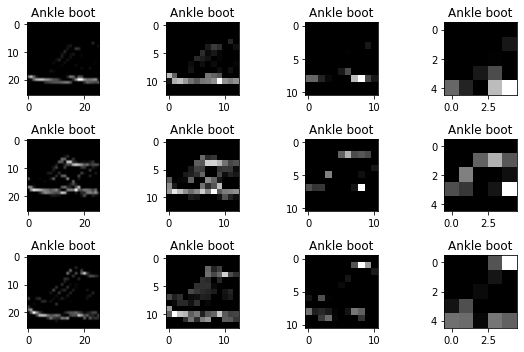

In [15]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 13

for x in range(0,4):
  f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[0,x].grid(False)
  axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
  f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[1,x].grid(False)
  axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
  f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[2,x].grid(False)
  axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
plt.tight_layout()

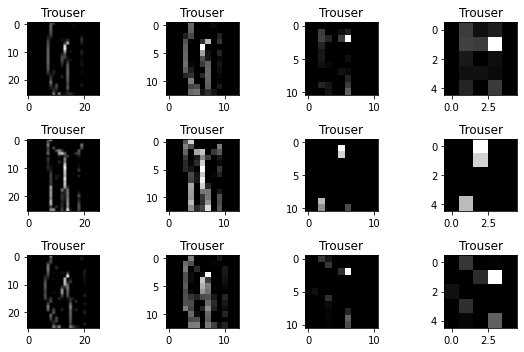

In [16]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 13

for x in range(0,4):
  f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[0,x].grid(False)
  axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
  f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[1,x].grid(False)
  axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
  f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[2,x].grid(False)
  axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
plt.tight_layout()

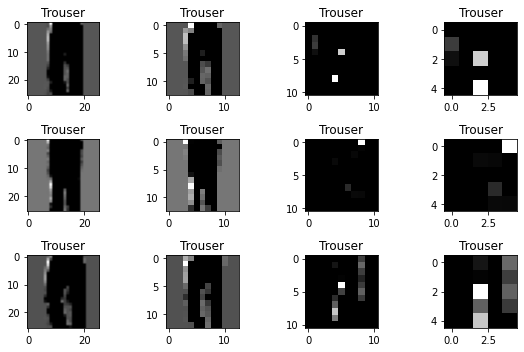

In [17]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 3

for x in range(0,4):
  f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[0,x].grid(False)
  axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
  f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[1,x].grid(False)
  axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
  f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[2,x].grid(False)
  axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
plt.tight_layout()

In [18]:
# 2. Fine-tuning a pre-trained VGG-19 CNN Model

# Here, we will use a VGG-19 model which was pre-trained on the ImageNet
# dataset by fine-tuning it on the Fashion-MNIST dataset.

# Reshaping Image Data for Modeling
"""
We do need to reshape our data before we train our model. Here we will 
convert the images to 3-channel images (image pixel tensors) as the VGG 
model was originally trained on RGB images """

train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


In [19]:
# Resizing Image Data for Modeling

import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [20]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.74 s, sys: 685 ms, total: 2.43 s
Wall time: 2.45 s


In [21]:
# Build CNN Model Architecture
# We will now build our CNN model architecture customizing the VGG-19 model.

# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

vgg_layers.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [22]:
# Set layers to trainable to enable fine-tuning
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3e573b4668> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e573b4cf8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e5743a7f0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3e573b0710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e5743aa90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3f1649d6a0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3e58418c18> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e58418710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e55245da0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e54808908> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3e551378d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3e54597

In [23]:
# Build CNN model on top of VGG19
# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [24]:
EPOCHS = 100
train_images_3ch_scaled = train_images_3ch / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.5278 - accuracy: 0.8241 - val_loss: 0.3106 - val_accuracy: 0.8903
Epoch 2/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.3156 - accuracy: 0.8947 - val_loss: 0.2797 - val_accuracy: 0.9042
Epoch 3/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.2589 - accuracy: 0.9112 - val_loss: 0.2605 - val_accuracy: 0.9087
Epoch 4/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.2263 - accuracy: 0.9218 - val_loss: 0.2315 - val_accuracy: 0.9158
Epoch 5/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.2021 - accuracy: 0.9298 - val_loss: 0.2304 - val_accuracy: 0.9183
Epoch 6/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.1787 - accuracy: 0.9374 - val_loss: 0.2485 - val_accuracy: 0.9172
Epoch 7/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.1608 - accuracy: 0.9436 - val_loss: 0

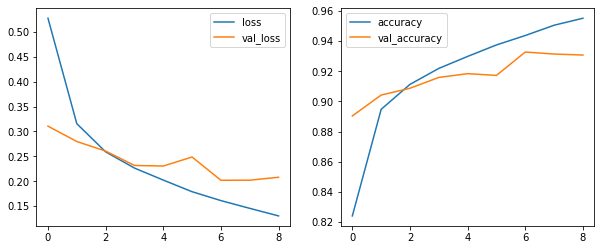

In [25]:
# Plot Learning Curves

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [26]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

array([[1.1090740e-07, 5.0362421e-09, 1.0555451e-09, 2.0574421e-07,
        3.0806390e-08, 2.4453789e-06, 7.8475047e-08, 1.9962154e-05,
        3.0517196e-08, 9.9997711e-01],
       [1.1122268e-04, 6.5818057e-07, 9.9944419e-01, 5.5995733e-06,
        4.5048131e-05, 9.2140817e-07, 3.9047954e-04, 3.6652833e-07,
        9.2976563e-07, 6.2483213e-07],
       [5.5059754e-14, 1.0000000e+00, 7.5729082e-13, 3.0556798e-12,
        3.2441667e-12, 4.2992798e-13, 2.3612034e-14, 3.8779870e-15,
        5.7917164e-13, 1.4086165e-14],
       [1.2273010e-10, 1.0000000e+00, 1.5059429e-09, 6.7371038e-09,
        3.1406249e-09, 5.3188831e-10, 8.3088335e-11, 2.1230049e-11,
        7.0162137e-10, 5.2285246e-11],
       [1.8109423e-01, 6.8956334e-04, 1.3265558e-02, 4.0331362e-03,
        3.6427286e-03, 4.0189933e-04, 7.9227525e-01, 1.0520107e-03,
        3.0578126e-03, 4.8773218e-04]], dtype=float32)

In [27]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [28]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.91      0.90      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.87      0.91      0.89      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.85      0.74      0.79      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.96      0.99      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,879,2,11,24,5,0,62,0,17,0
Trouser,1,987,0,9,0,0,1,0,2,0
Pullover,18,1,910,9,31,0,29,0,2,0
Dress,11,6,7,928,30,0,13,0,3,2
Coat,2,0,40,19,909,0,26,0,4,0
Sandal,0,0,0,0,0,991,0,7,0,2
Shirt,92,2,52,30,70,0,740,0,14,0
Sneaker,0,0,0,0,0,8,0,980,0,12
Bag,1,2,0,0,1,2,0,0,993,1
Ankle boot,0,0,0,0,0,6,0,35,1,958
